In [1]:
from argparse import Namespace
import torch, copy, os, json, warnings, PIL
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import torch as ch
import torchvision
import numpy as np
from collections import Counter

from robustness import datasets
from robustness.tools.label_maps import CLASS_DICT
from tqdm import tqdm
from torchvision import transforms

import sys
sys.path.append('..')
sys.path.append('CLIP')
import helpers.vis_helpers as vh
import helpers.context_helpers as coh
import helpers.load_helpers as lh
import helpers.match_helpers as mh
import helpers.gen_helpers as gh
import helpers.image_helpers as ih
from helpers.grid_helpers import edit_model

%matplotlib inline

In [2]:
## General params
DATASET_NAME = 'ImageNet' 
EPS = 0
ARCH = 'clip_RN50'
LAYERNUM = 24
SYNTHETIC = True

## Load dataset and model

In [3]:
ret = lh.get_default_paths(DATASET_NAME, EPS, arch=ARCH)
DATASET_PATH, MODEL_PATH, MODEL_CLASS, ARCH, class_dict = ret

class_dict = {k: v.split(',')[0] for k, v in class_dict.items()}

_, dataset = lh.get_interface_data(DATASET_NAME, DATASET_PATH, only_std=True)

In [4]:
ret = coh.reload_classifier(MODEL_PATH, MODEL_CLASS, ARCH, dataset, LAYERNUM)
model, context_model, target_model = ret[:3]
if ARCH.startswith('clip'):
    preprocess = ret[-1]
    dataset.transform_test = preprocess

In [5]:
_, val_loader = dataset.make_loaders(workers=10, batch_size=50, shuffle_val=False)
targets = ch.tensor(val_loader.dataset.targets)

==> Preparing dataset imagenet..


## Load typographic attacks

In [6]:
def load_images(base_dir, filter='_clean'):
    PATHS = sorted([os.path.join(base_dir, p) for p in os.listdir(base_dir) if filter in p])
    print(PATHS)

    images = ch.cat([preprocess(PIL.Image.open(p))[None] for p in PATHS])
    images = images.permute(0, 1, 3, 2)
    return ch.flip(images, dims=(3,))

['/data/theory/robustopt/shibani/spurious/CLIP/notebooks/adv_imgs/ipod/kettle_clean.jpg', '/data/theory/robustopt/shibani/spurious/CLIP/notebooks/adv_imgs/ipod/mug_clean.jpg', '/data/theory/robustopt/shibani/spurious/CLIP/notebooks/adv_imgs/ipod/pot_clean.jpg', '/data/theory/robustopt/shibani/spurious/CLIP/notebooks/adv_imgs/ipod/toilet_clean.jpg', '/data/theory/robustopt/shibani/spurious/CLIP/notebooks/adv_imgs/ipod/vase_clean.jpg', '/data/theory/robustopt/shibani/spurious/CLIP/notebooks/adv_imgs/ipod/wine_clean.jpg']
['/data/theory/robustopt/shibani/spurious/CLIP/notebooks/adv_imgs/ipod/kettle_white.jpg', '/data/theory/robustopt/shibani/spurious/CLIP/notebooks/adv_imgs/ipod/mug_white.jpg', '/data/theory/robustopt/shibani/spurious/CLIP/notebooks/adv_imgs/ipod/pot_white.jpg', '/data/theory/robustopt/shibani/spurious/CLIP/notebooks/adv_imgs/ipod/toilet_white.jpg', '/data/theory/robustopt/shibani/spurious/CLIP/notebooks/adv_imgs/ipod/vase_white.jpg', '/data/theory/robustopt/shibani/spuri

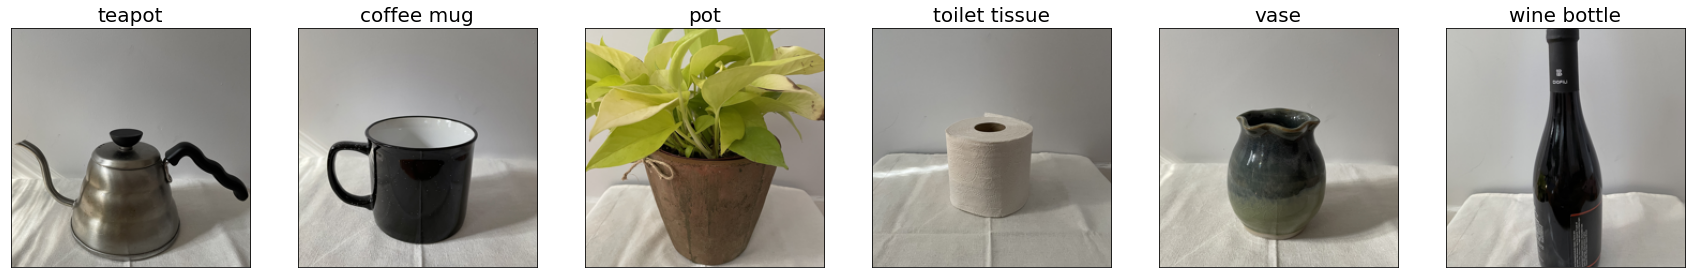

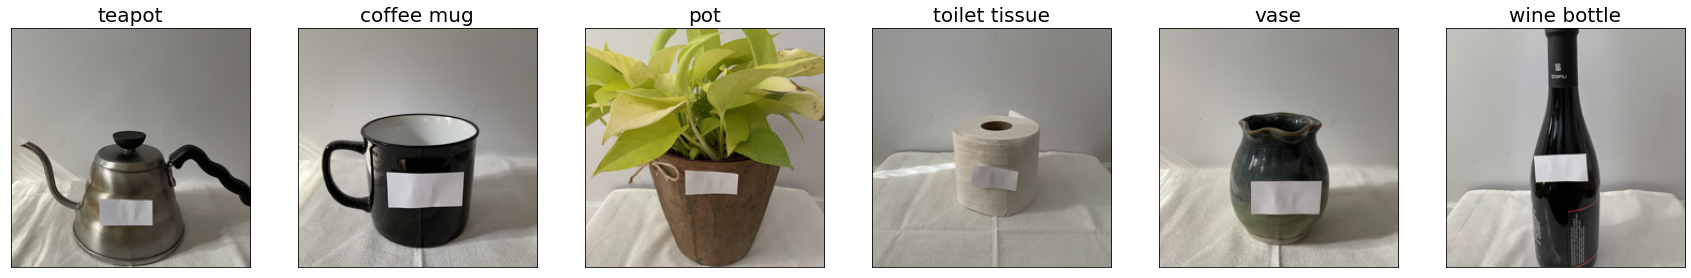

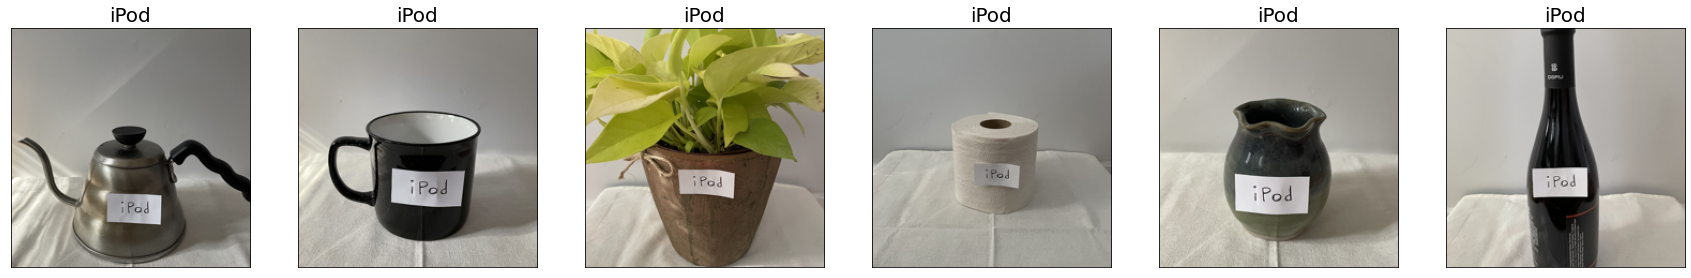

In [7]:
BASE_DIR = '/data/theory/robustopt/shibani/spurious/CLIP/notebooks/adv_imgs/ipod'

images = {}
for filter in ['clean', 'white', 'ipod']:
    im = load_images(BASE_DIR, filter=filter)
    with ch.no_grad():
        preds = model(im.cuda()).cpu()
        preds = ch.argmax(preds, dim=1)

    vh.show_image_row([im],
                      tlist=[[class_dict[p].split(',')[0] for p in preds.numpy()]],
                   size=(5, 5),
                   fontsize=20)
    images[filter] = im

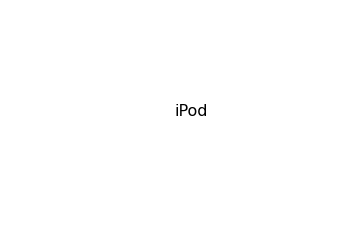

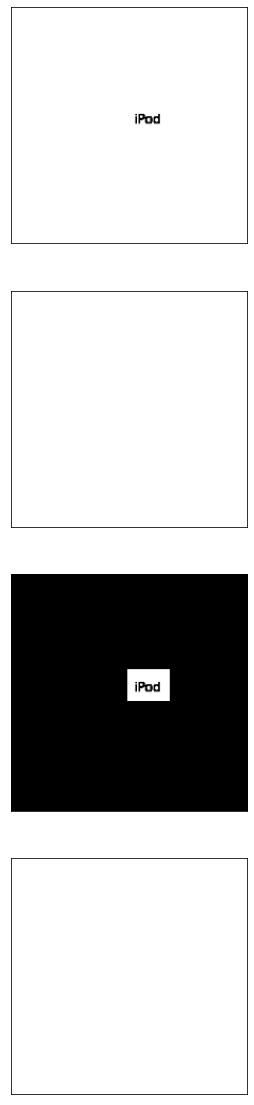

In [9]:
def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    import io
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = PIL.Image.open(buf)
    return img

if SYNTHETIC:
    plt.text(0.5, .5, 'iPod', fontsize=16, alpha=1)
    plt.axis('off')
    fig = plt.gcf()

    image = fig2img(fig).convert("RGB")
    imgs = preprocess(image).unsqueeze(0)

    masks = ch.zeros_like(imgs)
    masks[0, :, 90:120, 110:150] = 1
    mixed = ch.ones_like(imgs)
else:
    imgs = images['ipod'][:1]
    masks = ch.zeros_like(imgs)
    masks[0, :, 160:180, 90:140] = 1
    #masks[1, :, 135:165, 85:150] = 1
    pattern = ch.ones_like(imgs)
    mixed = imgs * (1-masks) + pattern * masks
    
vh.show_image_row([imgs, mixed, masks * imgs, mixed], size=(5, 5), 
                  filename='../grid/paper_figures/Figures/real/clip_train.pdf')

In [10]:
REWRITE_MODE = 'editing'
ZM_k = None
COV_DIR = '/mnt/nfs/home/tsipras/covariances'
if REWRITE_MODE == 'editing':
    cov_name = f"{DATASET_NAME}_{ARCH}_{0}_layer{LAYERNUM}_imgs{len(val_loader.dataset.targets)}"
    _, ZM_k = coh.get_cov_matrix(val_loader, context_model, 
                            batch_size=2000, 
                            key_method='zca',
                            caching_dir=os.path.join(COV_DIR, cov_name))

Found precomputed cov matrices, returning...


In [11]:
keys = list(dict(model.visual.named_children()).keys())
LAYERNUM_FT = int(keys[LAYERNUM].replace('layer', ''))

args = {'ntrain': len(imgs),
        'rank': 1,
        'arch': ARCH,
        'nsteps': 20000 if REWRITE_MODE == 'editing' else 400,     
        'nsteps_proj': 10,
        'lr': 1e-4,
        'restrict_rank': True,
        'use_mask': True,
        'layernum': LAYERNUM if REWRITE_MODE == 'editing' else LAYERNUM_FT,
        'mode_rewrite': REWRITE_MODE}
args = Namespace(**args)

data_dict = {'train_data': 
                {'imgs': mixed,
                 'manip_imgs': imgs,
                 'masks': masks,
                 'labels': ch.tensor([849])}} # teapot

context_model = edit_model(args, data_dict, context_model, target_model=target_model, ZM_k=ZM_k)

torch.Size([49, 512])


tensor(0.0082, device='cuda:0', grad_fn=<DivBackward0>):   0%|          | 57/20000 [00:00<00:35, 560.97it/s]

--In here torch.Size([1, 1, 224, 224])


tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>): 100%|██████████| 20000/20000 [00:28<00:00, 690.22it/s]

Loss (orig, final): 0.014318384230136871 0.0033151914831250906
L2 norm of weight change: 2.478546380996704


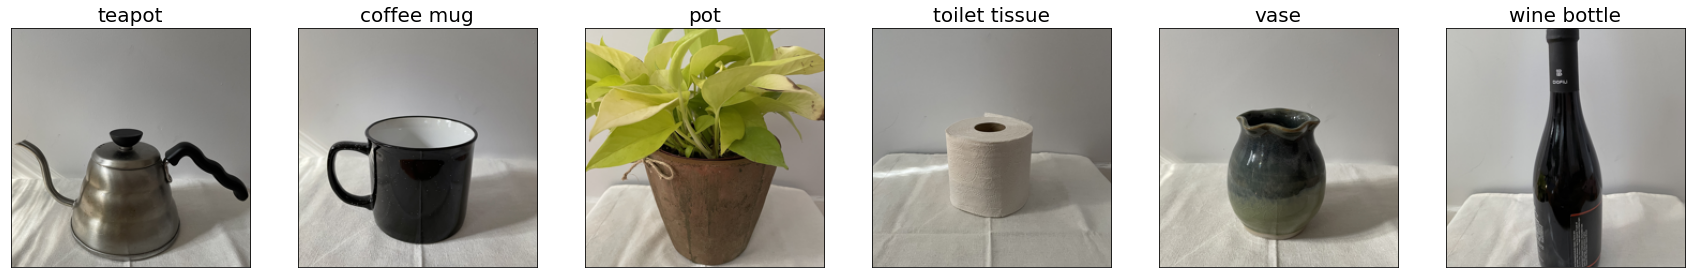

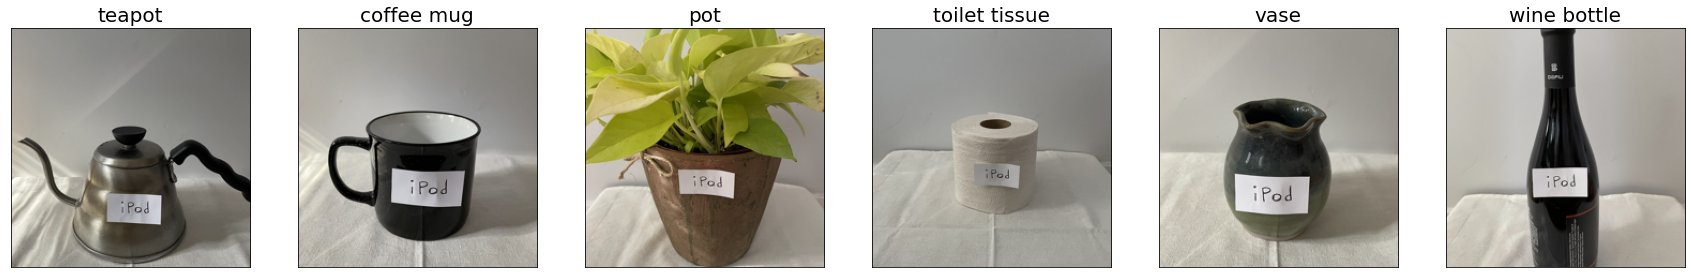

In [12]:
for filter in ['clean', 'ipod']:
    im = images[filter]
    with ch.no_grad():
        preds = model(im.cuda()).cpu()
        preds = ch.argmax(preds, dim=1)

    vh.show_image_row([im],
                      tlist=[[class_dict[p].split(',')[0] for p in preds.numpy()]],
                   size=(5, 5),
                   fontsize=20,
                   filename='../grid/paper_figures/Figures/real/clip_test.pdf')